<a href="https://colab.research.google.com/github/remmover/Borsch/blob/main/OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [9]:
df = pd.read_csv("/content/sample_data/bikes_rent.csv")

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

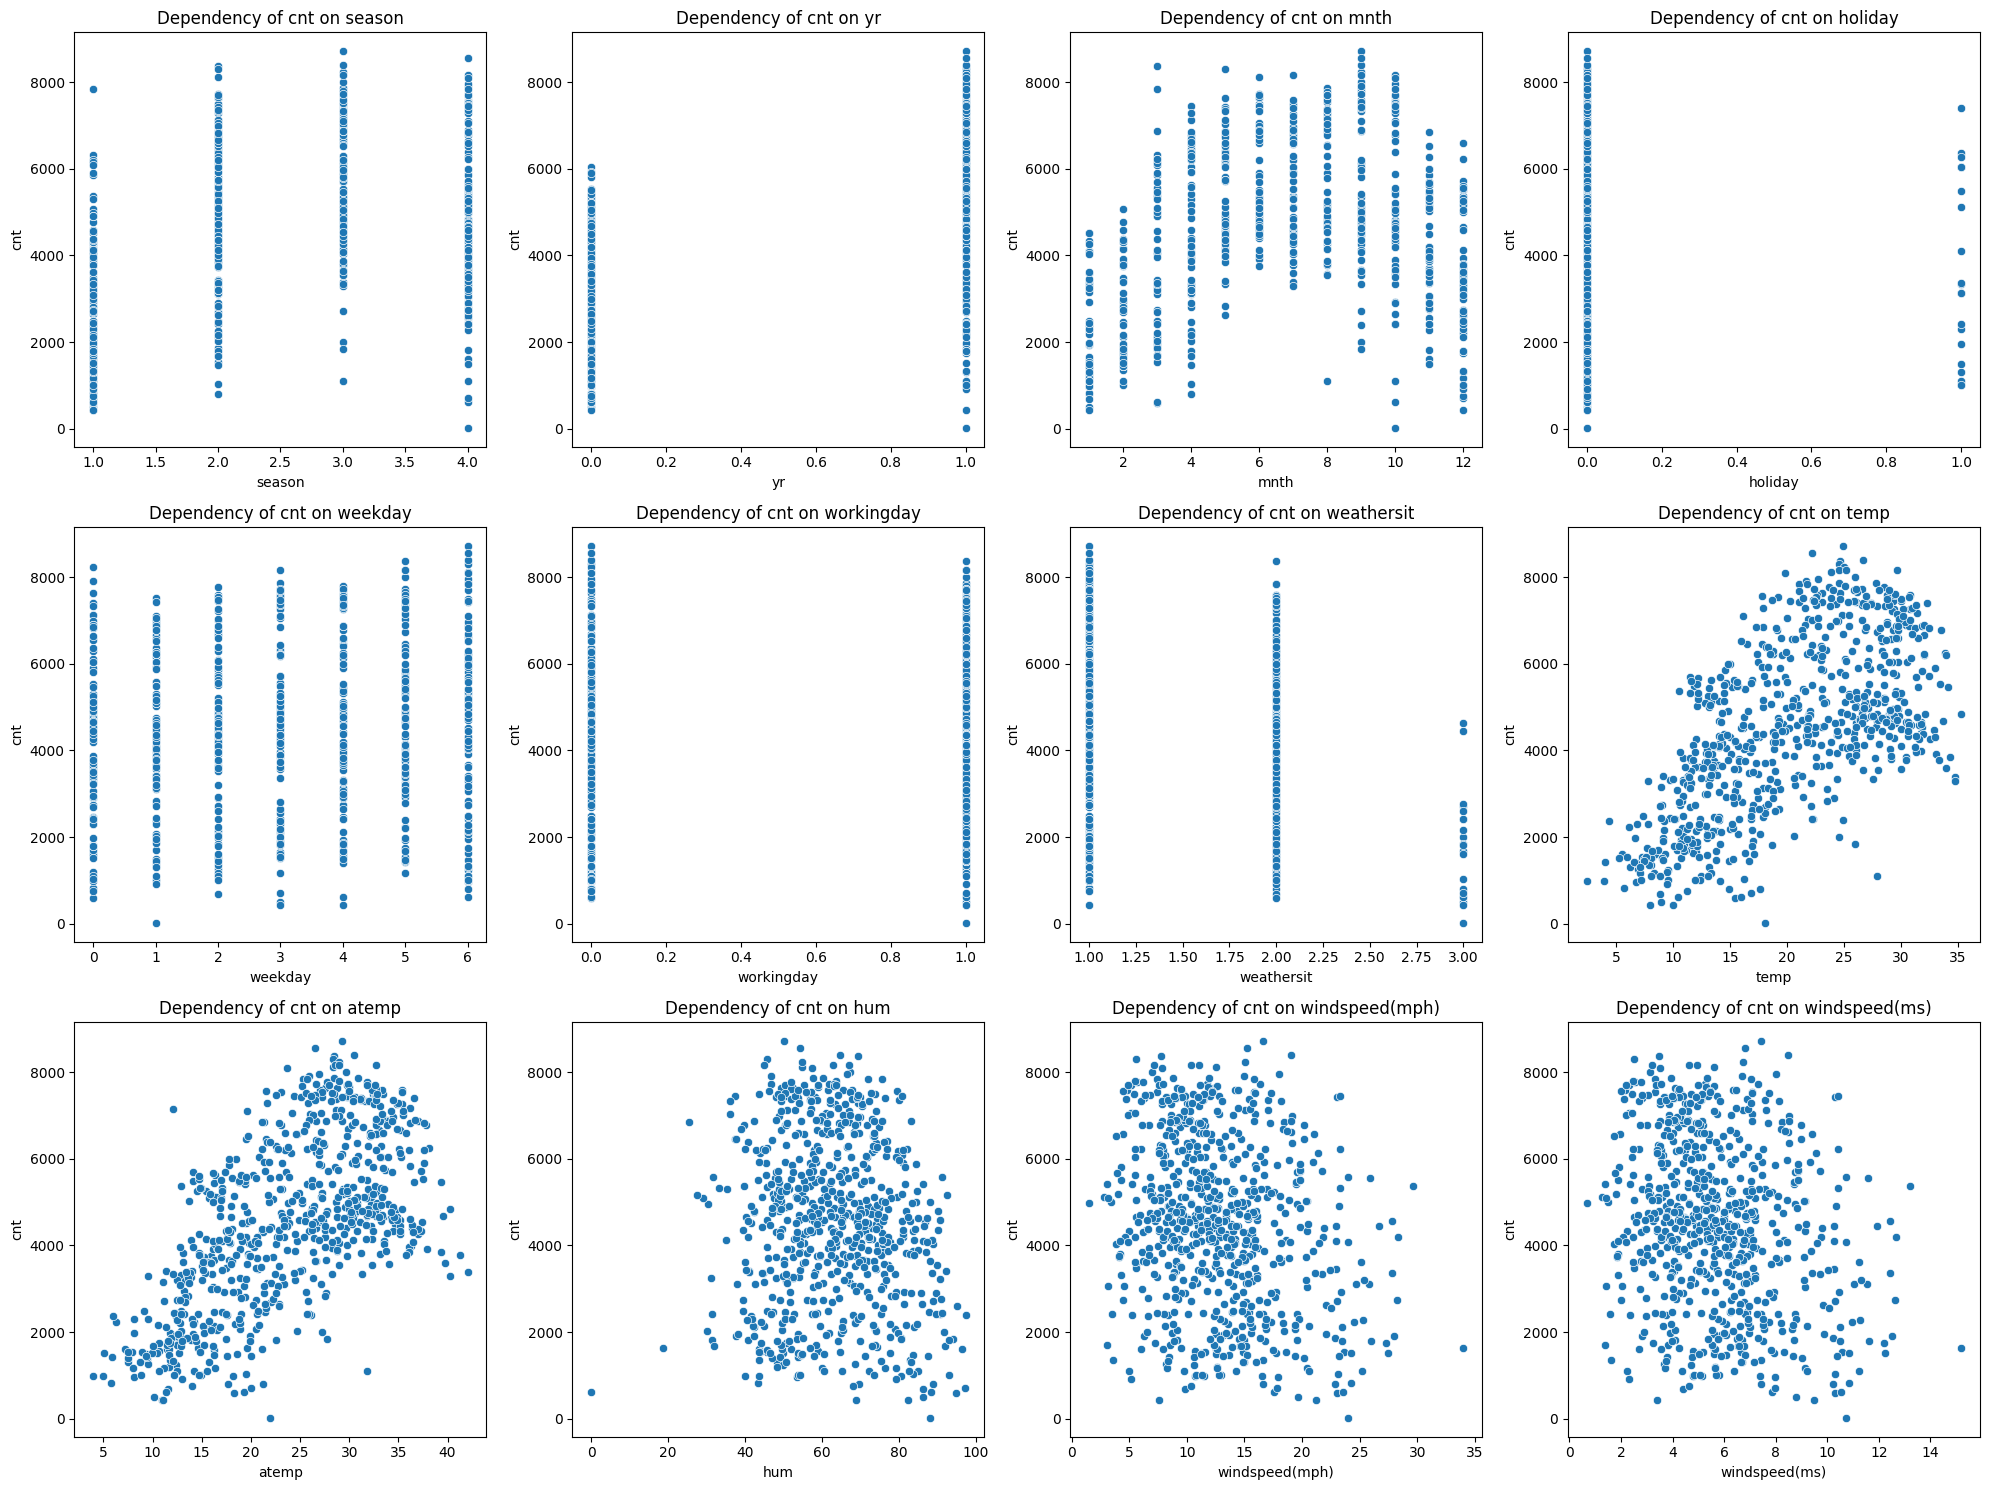

In [10]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday',
            'workingday', 'weathersit', 'temp', 'atemp',
            'hum', 'windspeed(mph)', 'windspeed(ms)']

# Create a figure with a grid of subplots (3 rows x 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# Loop over each feature and create a scatter plot of cnt vs. feature
for i, feature in enumerate(features):
    ax = axes[i]
    sns.scatterplot(x=feature, y='cnt', data=df, ax=ax)
    ax.set_title(f'Dependency of cnt on {feature}')  # Set plot title
    ax.set_xlabel(feature)  # Set x-axis label
    ax.set_ylabel('cnt')    # Set y-axis label

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Характер залежності від місяця (mnth)
З графіка видно, що кількість прокатів змінюється по сезонах: у тепліші місяці (приблизно з травня по вересень) прокатів більше, а в зимові (особливо січень, лютий, грудень) – менше. Тобто залежність має яскраво виражений сезонний характер, а не є лінійною.
Ознаки з лінійною залежністю
Якщо подивитися на графіки, найбільш помітний приблизно лінійний зв’язок із температурою (temp) та відчутною температурою (atemp): що вищі ці показники, то, загалом, більше прокатів.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [11]:
correlations = df.iloc[:, :-1].corrwith(df.iloc[:, -1])
correlations

,0
season,0.406100
yr,0.566710
mnth,0.279977
holiday,-0.068348
weekday,0.067443
workingday,0.061156
weathersit,-0.297391
temp,0.627494
atemp,0.631066
hum,-0.100659


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [12]:
selected_columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
df_selected = df[selected_columns]

# Calculate the pairwise correlation matrix
correlation_matrix = df_selected.corr()

correlation_matrix

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [13]:
feature_means = df.mean()
feature_means

,0
season,2.496580
yr,0.500684
mnth,6.519836
holiday,0.028728
weekday,2.997264
workingday,0.683995
weathersit,1.395349
temp,20.310776
atemp,23.717699
hum,62.789406


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [14]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [15]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [16]:
from sklearn.linear_model import LinearRegression


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [17]:
lr = LinearRegression()

# Train the model on the entire dataset
lr.fit(X, y)

# Print feature names with their corresponding coefficients (weights)
for feature, coef in zip(df_shuffled.columns[:-1], lr.coef_):
    print(feature, coef)

season 570.8637960129914
yr 1021.9653779400622
mnth -141.3017451148728
holiday -86.7593446245368
weekday 137.22506441350538
workingday 56.391881775973005
weathersit -330.2264620440312
temp 367.48373260182126
atemp 585.5493861188597
hum -145.61430569885857
windspeed(mph) 12457138390688.885
windspeed(ms) -12457138390887.346


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [20]:
from sklearn.linear_model import Lasso


lasso = Lasso()

# Train the model on the dataset
lasso.fit(X, y)

# Print the feature names along with their corresponding coefficients (weights)
for feature, coef in zip(df_shuffled.columns[:-1], lasso.coef_):
    print(feature, coef)

season 560.2416160308861
yr 1019.4634940657196
mnth -128.73062703678696
holiday -86.15278133371106
weekday 137.34789390496314
workingday 55.21237064135668
weathersit -332.3698569623487
temp 376.3632362096943
atemp 576.530793504555
hum -144.12915500348583
windspeed(mph) -197.1396894024843
windspeed(ms) -2.8051404183533485e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [22]:
from sklearn.linear_model import Ridge

ridge = Ridge()

# Train the model on the dataset
ridge.fit(X, y)

# Print the feature names along with their corresponding coefficients (weights)
for feature, coef in zip(df_shuffled.columns[:-1], ridge.coef_):
    print(feature, coef)

season 563.0645722520181
yr 1018.9483787875305
mnth -131.87332028247715
holiday -86.74609799709232
weekday 138.00511117871918
workingday 55.90311037506467
weathersit -332.34978849907367
temp 386.45788919190807
atemp 566.3470470600669
hum -145.07132729867195
windspeed(mph) -99.25944108179067
windspeed(ms) -99.25944115434177


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [23]:
alphas = np.arange(1, 500, 50)

# Initialize lists to store coefficients for Lasso and Ridge models
coefs_lasso = []
coefs_ridge = []

# Loop over each alpha value and fit the models
for alpha in alphas:
    # Lasso regression (L1 regularization)
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X, y)
    coefs_lasso.append(lasso.coef_)

    # Ridge regression (L2 regularization)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefs_ridge.append(ridge.coef_)

# Convert the lists of coefficients into NumPy arrays
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Print the resulting coefficient arrays
print("Lasso Coefficients:\n", coefs_lasso)
print("Ridge Coefficients:\n", coefs_ridge)

Lasso Coefficients:
 [[ 5.60241616e+02  1.01946349e+03 -1.28730627e+02 -8.61527813e+01
   1.37347894e+02  5.52123706e+01 -3.32369857e+02  3.76363236e+02
   5.76530794e+02 -1.44129155e+02 -1.97139689e+02 -2.80514042e-08]
 [ 4.10969632e+02  9.77019409e+02 -0.00000000e+00 -5.34489688e+01
   9.19434374e+01  1.75372118e+01 -3.18125568e+02  3.22829934e+02
   6.10031512e+02 -9.10689615e+01 -1.45066095e+02 -2.29892889e-08]
 [ 3.70077089e+02  9.35945490e+02  0.00000000e+00 -1.21619360e+01
   4.88886342e+01  0.00000000e+00 -3.08805664e+02  2.69417263e+02
   6.32502623e+02 -2.75042876e+01 -9.37749037e+01 -2.41657943e-08]
 [ 3.32835717e+02  8.91870058e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.79616688e+02  2.11052030e+02
   6.62920880e+02 -0.00000000e+00 -5.01551472e+01 -2.62789872e-08]
 [ 2.98134448e+02  8.45652857e+02  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00 -2.35571345e+02  1.24144807e+02
   7.25379483e+02 -0.00000000e+00 -1.26461769e+01 -

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

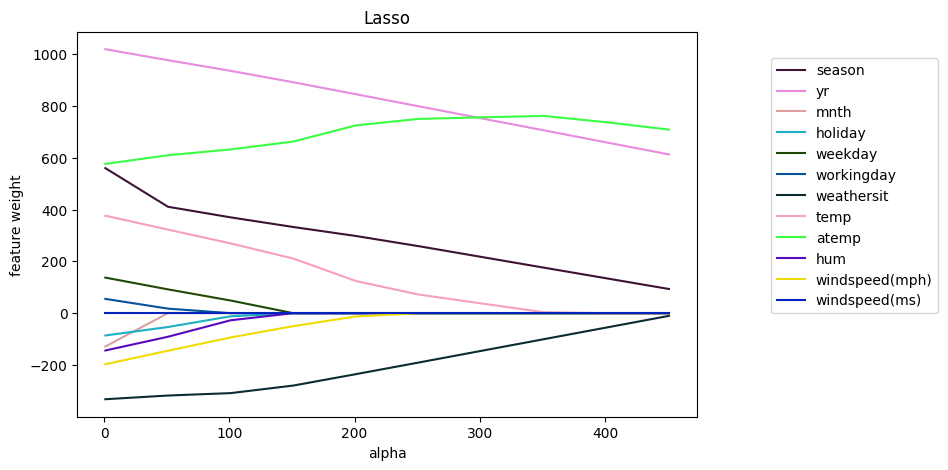

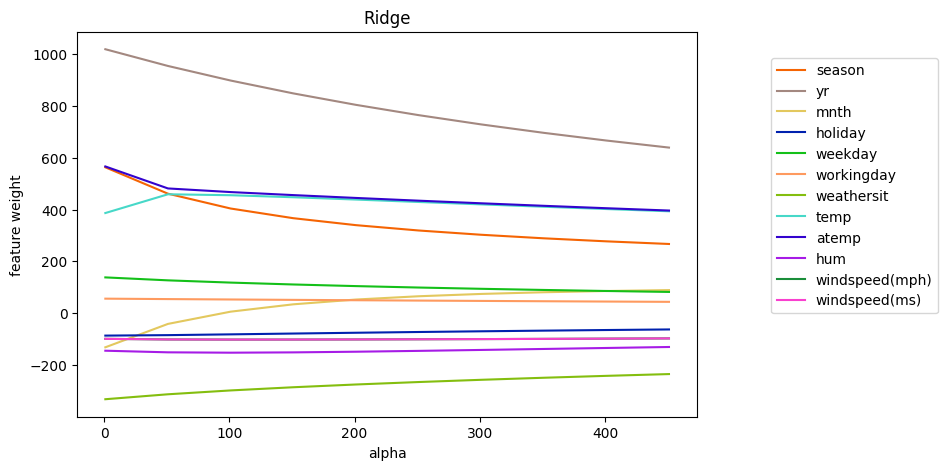

In [24]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1.
Lasso (L1-регуляризація) зазвичай сильніше “стискає” ваги, оскільки може обнулювати деякі з них. Ridge (L2-регуляризація) зменшує абсолютні значення коефіцієнтів, але не приводить їх до нуля.

2.
Якщо коефіцієнт регуляризації
α
α у Lasso зробити дуже великим, то більшість (або навіть усі) ваги стануть рівними нулю. Це відбувається через особливість L1-регуляризації, яка штрафує суму модулів коефіцієнтів і “вигідніше” встановити деякі з них у нуль, ніж робити їх просто малими.

3.
Lasso. Так, із графіків (та зазвичай на практиці) помітно, що для будь-якого
α>0 одна з ознак windspeed стає (або залишається) фактично нульовою. За критерієм “менше
10 ^−3
 ” можна вважати її виключеною.
Ridge. L2-регуляризація не встановлює коефіцієнти точно в нуль, а лише зменшує їхню величину. Тому Ridge не “виключає” жодну з ознак windspeed повністю (коефіцієнти залишаються відмінними від нуля).

4.
Lasso (L1-регуляризація) краще підходить для відбору ознак, оскільки здатен обнуляти ваги при неінформативних змінних, фактично “відкидаючи” їх.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [27]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))

    plt.plot(x, y, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()


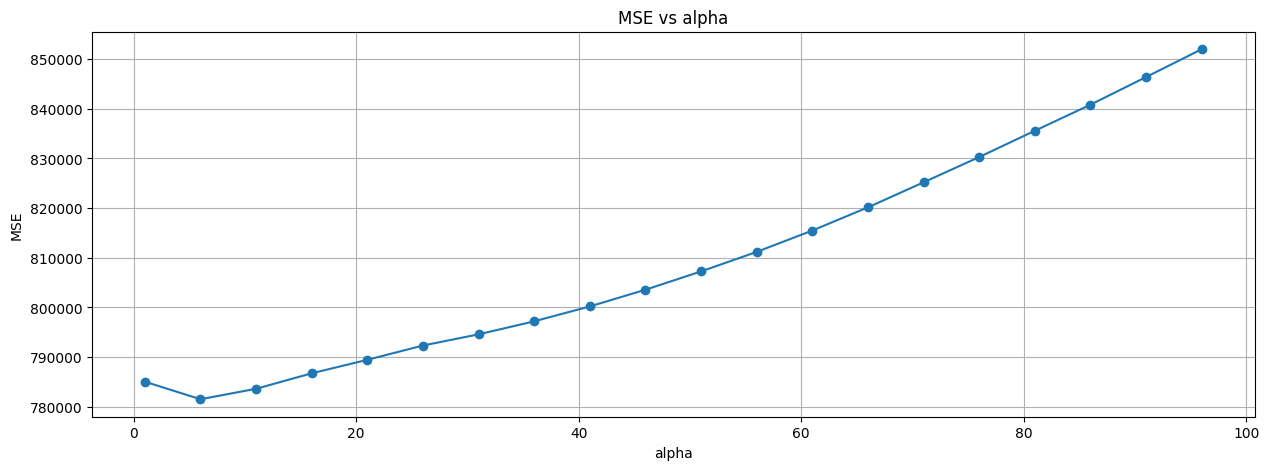

Chosen alpha: 6
season 532.0189828413535
yr 1015.0602226430595
mnth -100.03952614356629
holiday -83.29395987529904
weekday 132.50446549095795
workingday 51.557085614073735
weathersit -330.5598567399817
temp 370.67985503003405
atemp 581.396931065498
hum -140.00740550068844
windspeed(mph) -191.77140847135036
windspeed(ms) -2.6854702314758792e-08


In [28]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, random_state=42)
regressor.fit(X, y)

mean_mse = np.mean(regressor.mse_path_, axis=1)

data_for_plot = list(zip(regressor.alphas_, mean_mse))
create_plot(data_for_plot, "MSE vs alpha", "alpha", "MSE")

print("Chosen alpha:", regressor.alpha_)

for feature_name, coef_value in zip(df_shuffled.columns[:-1], regressor.coef_):
    print(feature_name, coef_value)

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Best alpha for fold 1: 6


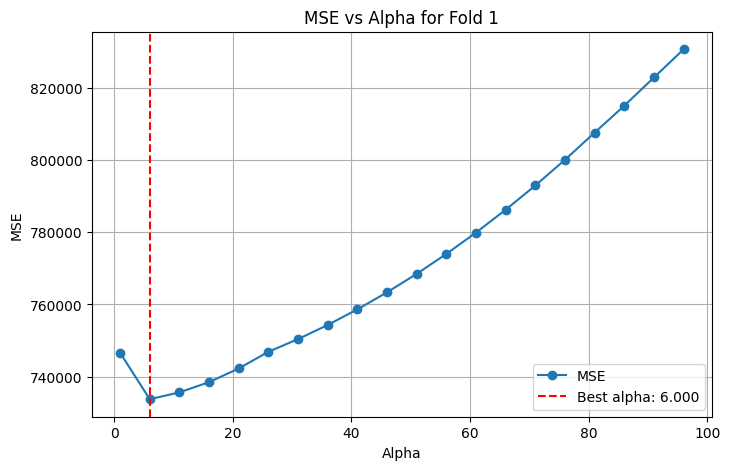

Best alpha for fold 2: 1


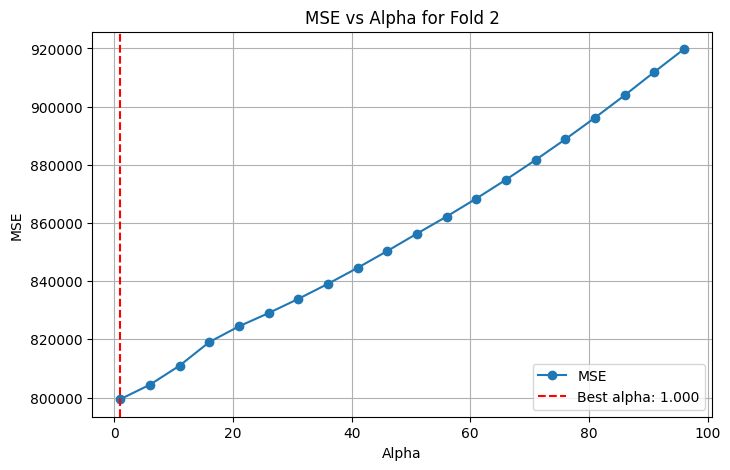

Best alpha for fold 3: 51


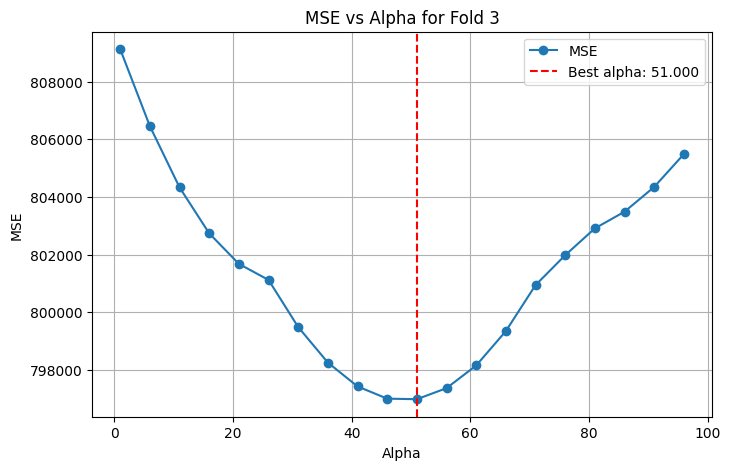

In [29]:
regressor = LassoCV(alphas=alphas, cv=3, random_state=42, max_iter=10000)
regressor.fit(X, y)

# mse_path_ is of shape (n_alphas, n_folds)
n_folds = regressor.mse_path_.shape[1]

# Iterate over folds and for each fold:
# 1. Find the best alpha (corresponding to minimum MSE)
# 2. Plot the MSE vs. alpha for that fold and mark the best alpha
for i in range(n_folds):
    mse_fold = regressor.mse_path_[:, i]
    best_index = np.argmin(mse_fold)
    best_alpha = regressor.alphas_[best_index]
    print(f"Best alpha for fold {i+1}: {best_alpha}")

    plt.figure(figsize=(8, 5))
    plt.plot(regressor.alphas_, mse_fold, marker='o', label='MSE')
    plt.axvline(best_alpha, color='red', linestyle='--',
                label=f"Best alpha: {best_alpha:.3f}")
    plt.title(f"MSE vs Alpha for Fold {i+1}")
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [30]:
Чотири ознаки з найбільшими (позитивними) коефіцієнтами
yr (0 — 2011, 1 — 2012): коефіцієнт часто найбільший і позитивний, що свідчить про збільшення попиту в 2012 році порівняно з 2011.
temp (температура, °C): що тепліше, то більше охочих їздити на велосипеді.
atemp (відчутна температура, °C): діє аналогічно до temp.
season (1 — весна, 2 — літо, 3 — осінь, 4 — зима): оскільки літо й осінь (2 і 3) зазвичай комфортніші для катання, у моделі це відображається одним числом, яке зростає з весни до зими, але здебільшого дає позитивний внесок у прогноз порівняно із зимою.

Чи видно зростаючу лінійну залежність на графіках?
Для температури (temp, atemp) зазвичай помітний чіткий тренд: що вища температура, то більше оренд. Цей тренд досить близький до лінійного.
Для yr фактично це дві “точки” (0 чи 1), і ми бачимо, що при yr = 1 (2012 рік) середнє значення cnt вище, ніж при yr = 0.
Для season залежність «по місяцях» чи «по сезонах» швидше має сезонний (циклічний) характер, але загалом тепліші сезони дають вищий попит.

Чи логічно, що більші значення цих ознак збільшують попит?
Так. Тепла пора й комфортна погода (вища температура) спонукають людей їздити на велосипедах частіше.
Перехід з 2011 на 2012 рік у цьому датасеті зазвичай відбиває загальне зростання популярності сервісу.

SyntaxError: invalid character '—' (U+2014) (<ipython-input-30-b6f61302a1da>, line 3)

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [ ]:
Три ознаки з найбільшими за модулем негативними коефіцієнтами
weathersit (1 — ясний день, 4 — сильна злива): що гірша погода (більше число), то менший попит.
hum (вологість): що більша вологість, то менш комфортно, і попит знижується.
windspeed(mph) чи windspeed(ms) (швидкість вітру): сильніший вітер зменшує бажання їхати на велосипеді.

Чи видно зменшення на графіках?
Вологість та швидкість вітру зазвичай показують тренд: що вищі ці значення, то нижче cnt. Це може бути менш чітка лінійна залежність, але негативний тренд простежується.
weathersit кодується цілими числами (1, 2, 3, 4), і при гіршій погоді (3 або 4) кількість поїздок справді падає.

Чи логічно?
Цілком: у погану погоду (дощ, сильний вітер, висока вологість) люди рідше обирають велосипед.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [ ]:
Ознаки з коефіцієнтами, близькими до нуля (< 1e-3)
holiday (0 чи 1): у деяких містах і вибірках немає яскравої відмінності між вихідним/святковим днем і звичайним, або це вже враховується іншими змінними (workingday, weekday).
Одна з двох швидкостей вітру (windspeed(mph) чи windspeed(ms)) може “обнулитися”, бо дублює інформацію про ту саму швидкість вітру в інших одиницях.
weekday (день тижня) іноді має дуже слабкий внесок, якщо “робочість” дня (workingday) уже врахована або вплив буднів/вихідних перекрито іншими факторами.

Чому модель виключила їх?
Дублювання інформації. Якщо дві ознаки несуть практично однакову інформацію (наприклад, швидкість вітру у милях/год і м/с), модель “обнулює” одну з них, бо немає потреби тримати обидві.
Низька інформативність. Якщо ознака мало впливає на кінцевий результат або її ефект перекривається іншими факторами, модель з L1-регуляризацією (Lasso) схильна обнуляти такий коефіцієнт, аби зменшити “штраф” за складність.

Чи справді вони «ніяк» не впливають?
Не обов’язково «ніяк». Можливо, вплив настільки малий, що в межах цієї моделі його вигідніше вважати нульовим. Також може бути, що вплив ознаки вже враховано корельованою з нею змінною.
Lasso прагне до “розрідженого” (sparce) розв’язку, і саме тому може встановити вагу в нуль, навіть якщо реальний вплив існує, але дуже малий порівняно з іншими ознаками.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.